# Fit GMM by EM algorithm

*Please convert your coding notebook from .ipynb into <span style="color:red">.pdf</span> and concatenate it with your writing part.*

You need to implement the EM algorithm, using closed-forms derived in './HW4-Writing.pdf/2(b)'.

In [63]:
import matplotlib.pyplot as plt
# Do NOT change this cell.
import numpy as np

In [64]:
# E-step: compute posterior probabilities h_{li}
def probabilities(data, weights, means, covariances):
    '''
    :param data: size: (N, D)
    :param weights: corresponds to \pi, size: (K,)
    :param means: corresponds to \mu, size: (K, D)
    :param covariances: corresponds to \sigma, size: (K, D, D)
    :return prob_matrix: a matrix filled by posterior probability h_{ik}, size (N, K)
    '''
    num_data = len(data)
    num_clusters = len(means)
    prob_matrix = np.zeros((num_data, num_clusters))
    ########## START YOUR CODE HERE ##########
    cov_inv = np.zeros_like(covariances)
    cov_det = np.zeros(num_clusters)
    for k in range(num_clusters):
        cov_inv[k] = np.linalg.inv(covariances[k])
        cov_det[k] = np.linalg.det(covariances[k])
    cov_det = np.power(cov_det,[-1/2])
    for l in range(num_data):
        exp_value = np.zeros(num_clusters)
        for i in range(num_clusters):
            DM = data[l] - means[i]
            exp_value[i] = -1 / 2 * (np.matrix.transpose(DM) @ cov_inv[i] @ DM)
        exp_value = np.exp(exp_value)
        denominator = np.matrix.transpose(cov_det * exp_value) @ weights
        numerator = cov_det * exp_value * weights
        prob_matrix[l] = numerator / denominator
    ########## END YOUR CODE HERE ##########
    return prob_matrix

In [65]:
# M-step: update weights \pi, means \mu, and covariances \sigma
def updates(data, prob_matrix, weights, means, covariances):
    num_clusters = len(means)
    num_data = len(data)
    dim = data.shape[1]

    ########## START YOUR CODE HERE ##########
    prob_sum = np.sum(prob_matrix, axis=0)
    weights = prob_sum / num_data
    for i in range(num_clusters):
        means[i] = np.matrix.transpose(prob_matrix[..., i]) @ data / prob_sum[i]
        numerator = np.zeros([dim, dim])
        for l in range(num_data):
            DM = np.expand_dims(data[l] - means[i], axis=1)
            numerator += prob_matrix[l, i] * (DM @ np.matrix.transpose(DM))
        covariances[i] = numerator / prob_sum[i]
    ########## END YOUR CODE HERE ##########

    return weights, means, covariances

To help us develop and test our implementation, we will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians.

In [66]:
# Generate dataset

def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than
        #  or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]
        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)
    return data


# Model parameters
data_means = np.array([
    [5, 0],  # mean of cluster 1
    [1, 1],  # mean of cluster 2
    [0, 5]  # mean of cluster 3
])
data_covariances = np.array([
    [[.5, 0.], [0, .5]],  # covariance of cluster 1
    [[.92, .38], [.38, .91]],  # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
])
data_weights = np.array([1 / 4., 1 / 2., 1 / 4.])  # weights of each cluster

np.random.seed(4)
data = np.array(generate_MoG_data(100, data_means, data_covariances, data_weights))

Now plot the data you created above. The plot should be a scatterplot with 100 points that appear to roughly fall into three clusters.

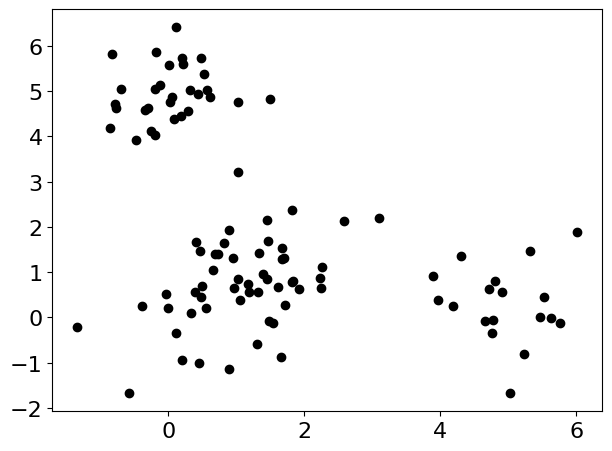

In [67]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:, 0], d[:, 1], 'ko')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.show()

Now we'll fit a mixture of Gaussians to this data using our implementation of the EM algorithm. As with k-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this simple case, we'll take three random points to be the initial cluster means, use the empirical covariance of the data to be the initial covariance in each cluster (a clear overestimate), and set the initial mixing weights to be uniform across clusters.

In [68]:
# Initialization of parameters
np.random.seed(4)
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = np.array([data[x] for x in chosen])
initial_covariances = np.array([np.cov(data, rowvar=False)] * 3)
initial_weights = np.array([1 / 3., 1 / 3., 1 / 3.])

We will use the following plot_contours() function to visualize the Gaussian components over the data at three different points in the algorithm's execution:

1. At initialization (using initial_means, initial_covariances, and initial_weights)
2. After running the algorithm to completion
3. After 20 iterations

In [69]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    Xmu = X - mux
    Ymu = Y - muy
    rho = sigmaxy / (sigmax * sigmay)
    z = Xmu ** 2 / sigmax ** 2 + Ymu ** 2 / sigmay ** 2 - 2 * rho * Xmu * Ymu / (sigmax * sigmay)
    denom = 2 * np.pi * sigmax * sigmay * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom


def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data], 'ko')  # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1] / (sigmax * sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors=col[i])
        plt.title(title)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.show()

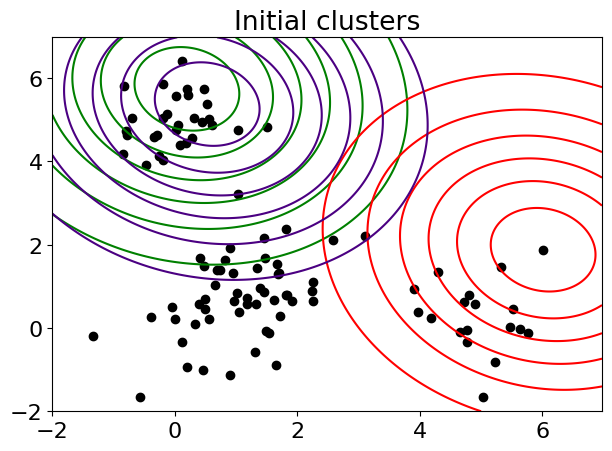

In [70]:
# Parameters after initialization
plot_contours(data, initial_means, initial_covariances, 'Initial clusters')

Now run the EM algorithm and plot contours afterwards.

In [71]:
# Run EM
my_means = initial_means
my_weights = initial_weights
my_covariances = initial_covariances
iters = 20
for iter in range(iters):
    # Here we run 20 iterations. You can use a more strict convergence criterion,
    # such as that the increment of the log-likelihood function is less than 1e-3
    prob_matrix = probabilities(data, my_weights, my_means, my_covariances)
    [my_weights, my_means, my_covariances] = updates(data, prob_matrix, my_weights, my_means, my_covariances)
print("my_weights =\n{},\n\nmy_means =\n{},\n\nmy_covariances =\n{}".format(my_weights, my_means, my_covariances))

my_weights =
[0.30100743 0.17993525 0.51905733],

my_means =
[[0.02238127 4.94603136]
 [4.94240545 0.31364134]
 [1.08184868 0.73761235]],

my_covariances =
[[[ 0.29398303  0.04872587]
  [ 0.04872587  0.35540776]]

 [[ 0.35562857 -0.01493194]
  [-0.01493194  0.66694074]]

 [[ 0.67155363  0.3308503 ]
  [ 0.3308503   0.90125037]]]


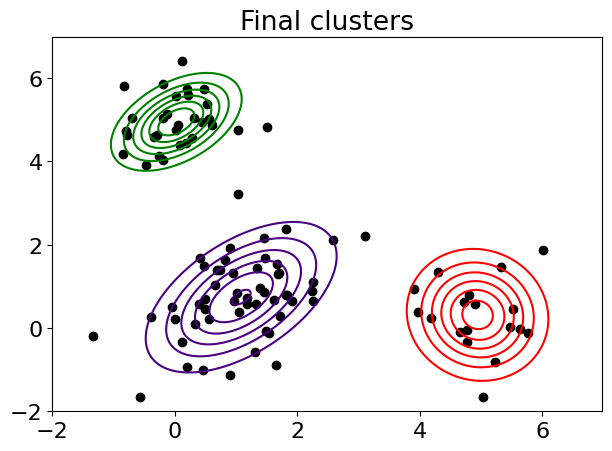

In [72]:
# Parameters after running EM to convergence
plot_contours(data, my_means, my_covariances, 'Final clusters')

Now call the GaussianMixture() method in sklearn package, and see its performance.

In [73]:
from sklearn.mixture import GaussianMixture

gmm_sklearn = GaussianMixture(n_components=3, covariance_type='full',
                              max_iter=20, weights_init=initial_weights,
                              means_init=initial_means).fit(data)
print("weights_sklearn =\n{},\n\nmeans_sklearn =\n{},\n\ncovariance_sklearn =\n{}".format(gmm_sklearn.weights_,
                                                                                          gmm_sklearn.means_,
                                                                                          gmm_sklearn.covariances_))

weights_sklearn =
[0.30089166 0.17993589 0.51917245],

means_sklearn =
[[0.02199279 4.94669312]
 [4.9424009  0.31364545]
 [1.08183436 0.73816636]],

covariance_sklearn =
[[[ 0.29370389  0.04941099]
  [ 0.04941099  0.3543986 ]]

 [[ 0.35563482 -0.01493779]
  [-0.01493779  0.66694506]]

 [[ 0.67139816  0.33074842]
  [ 0.33074842  0.90243587]]]


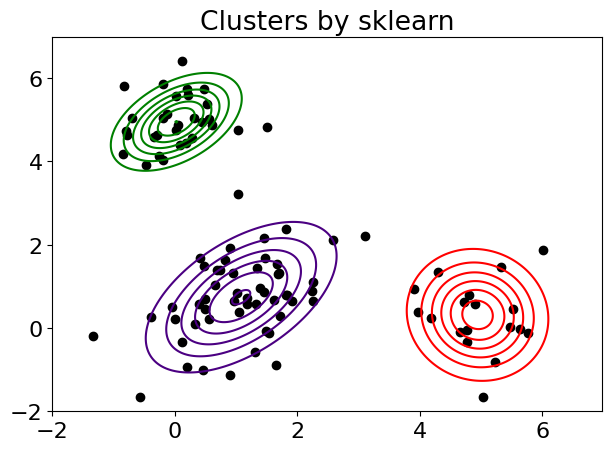

In [74]:
# Parameters after running EM to convergence
plot_contours(data, gmm_sklearn.means_, gmm_sklearn.covariances_, 'Clusters by sklearn')

Now see the differences of parameters of your algorithm and that of sklearn. You should see the precision is at least **1e-3**.

In [75]:
print("After 20 iterations, differences between our algorithm and sklearn:\n")
print("delta_weights =\n{},\n\ndelta_means =\n{},\n\ndelta_covariances=\n{}".format(my_weights - gmm_sklearn.weights_,
                                                                                    my_means - gmm_sklearn.means_,
                                                                                    my_covariances - gmm_sklearn.covariances_))

After 20 iterations, differences between our algorithm and sklearn:

delta_weights =
[ 1.15770227e-04 -6.45837833e-07 -1.15124389e-04],

delta_means =
[[ 3.88483410e-04 -6.61764743e-04]
 [ 4.55441691e-06 -4.11036858e-06]
 [ 1.43250214e-05 -5.54005410e-04]],

delta_covariances=
[[[ 2.79146961e-04 -6.85120337e-04]
  [-6.85120337e-04  1.00916157e-03]]

 [[-6.25209629e-06  5.85161700e-06]
  [ 5.85161700e-06 -4.31164803e-06]]

 [[ 1.55477197e-04  1.01874776e-04]
  [ 1.01874776e-04 -1.18549656e-03]]]
